## Data Import and Preprocessing
### Movie Data

In [1]:
import pandas as pd

pd.set_option('display.max_columns', None)

# Load movie data
movies = pd.read_csv("data/omdb_enriched_data.csv")
movies.head(1)

,title,release_date,original_language,genres,budget,revenue,runtime,year,Rated,Poster,Ratings,Metascore,imdbRating,imdbVotes,imdbID
0,Meg 2: The Trench,2023-08-02,en,Action-Science Fiction-Horror,129000000.0,352056482.0,116.0,2023.0,PG-13,posters/Meg_2:_The_Trench_2023_photo.jpg,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,5.0,"86,089",tt9224104


In [2]:
# Drop unused columns
movies.drop(columns=['imdbID', 'imdbVotes', 'Metascore', 'year', 'original_language'], inplace=True)

In [3]:
# Drop duplicate movies
movies = movies.drop_duplicates(subset=['title'], keep='first', inplace=False)

In [4]:
# Convert release_date to datetime and extract Month
movies['release_date'] = pd.to_datetime(movies['release_date'])
movies['Month'] = movies['release_date'].dt.strftime('%m-%Y')

# Drop release_date column
movies = movies.drop(columns=['release_date'])

In [5]:
# Map 'Rated' to numerical values
rating_map = {
    'G': 0,
    'PG': 1,
    'PG-13': 2,
    'R': 3,
    'NC-17': 4
}
movies['Age Rating'] = movies['Rated'].map(rating_map)

# Handle missing values by assigning -1
movies['Age Rating'] = movies['Age Rating'].fillna(-1)

# Drop the original 'Rated' column
movies = movies.drop(columns=['Rated'])

In [6]:
import numpy as np

# Turn string representations of Ratings dictionary into actual python object
movies['Ratings'] = movies['Ratings'].apply(lambda x: eval(x) if isinstance(x, str) else x)

# Function to extract Rotten Tomatoes ratings
def extract_rt_rating(ratings_list):
    if isinstance(ratings_list, list):
        for rating in ratings_list:
            if rating['Source'] == 'Rotten Tomatoes':
                return float(rating['Value'].replace('%', '')) / 10  # Convert percentage to 0-10 scale
    return np.nan

# Apply the function to extract RT_Rating
movies['RT_Rating'] = movies['Ratings'].apply(extract_rt_rating)

# Drop the Ratings column if no longer needed
movies.drop(columns=['Ratings'], inplace=True)

In [7]:
# Fill missing IMDb and RT ratings with their respective medians
movies['imdbRating'] = movies['imdbRating'].fillna(movies['imdbRating'].median())
movies['RT_Rating'] = movies['RT_Rating'].fillna(movies['RT_Rating'].median())

In [8]:
# Fill any missing genre values
movies['genres'] = movies['genres'].fillna('') 

# Split genres and get all unique genres
genres_split = movies['genres'].str.split('-', expand=True)
all_genres = set(genres_split.stack())  # Get unique genres

# Create one-hot encoded columns for each genre
for genre in all_genres:
    movies[genre] = movies['genres'].apply(lambda x: 1 if genre in x.split('-') else 0)

# Drop the original genres column
movies = movies.drop(columns=['genres'])


In [9]:
# Fill missing values with the median
movies['budget'] = movies['budget'].fillna(movies['budget'].median())
movies['revenue'] = movies['revenue'].fillna(movies['revenue'].median())

In [10]:
# Fill missing runtime with the mean value
movies['runtime'] = movies['runtime'].fillna(movies['runtime'].mean())

In [11]:
# Poster is of greater importance to the project so drop rows where Poster is missing
movies = movies.dropna(subset=['Poster'])

In [12]:
from sklearn.preprocessing import StandardScaler

# Standardize numerical variables to better suit NN model
scaler = StandardScaler()
movies[['budget', 'revenue', 'runtime', 'imdbRating', 'RT_Rating']] = scaler.fit_transform(movies[['budget', 'revenue', 'runtime', 'imdbRating', 'RT_Rating']])

In [13]:
#Transformed Movie Data
movies.head()

,title,budget,revenue,runtime,Poster,imdbRating,Month,Age Rating,RT_Rating,,TV Movie,Documentary,Western,Action,Thriller,Crime,Adventure,Drama,Family,Horror,Music,Comedy,Romance,War,Fantasy,Animation,Mystery,History,Science Fiction
0,Meg 2: The Trench,2.548242,1.668476,0.430060,posters/Meg_2:_The_Trench_2023_photo.jpg,-1.352857,08-2023,2.0,-1.115544,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,The Pope's Exorcist,-0.182831,-0.055939,-0.142648,posters/The_Pope's_Exorcist_2023_photo.jpg,-0.257718,04-2023,3.0,-0.250008,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,Deadpool & Wolverine,4.295145,7.535319,0.958713,posters/Deadpool_&_Wolverine_2024_photo.jpg,1.534328,07-2024,3.0,0.803689,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,Transformers: Rise of the Beasts,4.295145,1.999587,0.914659,posters/Transformers:_Rise_of_the_Beasts_2023_...,-0.357276,06-2023,2.0,-0.212376,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,Dune: Part Two,4.049102,3.666122,2.676838,posters/Dune:_Part_Two_2024_photo.jpg,2.131676,02-2024,2.0,1.330537,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


### Crime Data

In [14]:
# Load crime data
Reports = pd.read_csv("data/States_Reports.csv")

# Inspect the structure of the Reports data
# Reports.info()

In [15]:
# Drop Florida (inconsistent data) and Utah.1 (duplicated column)
Reports = Reports.drop(columns=['Florida', 'Utah.1'])
# Drop rows with missing values
Reports = Reports.dropna()
Reports.head(2)

,Month,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Washington,West Virginia,Wisconsin,Wyoming
0,10-2014,8196.0,1094.0,7581.0,4719.0,34958.0,4151.0,3227.0,1652.0,2270.0,11895.0,451.0,1315.0,4482.0,5829.0,2472.0,2652.0,3466.0,6862.0,942.0,7197.0,6980.0,12901.0,3685.0,2233.0,7533.0,978.0,1770.0,4602.0,1495.0,6792.0,2290.0,13821.0,10770.0,897.0,12860.0,4483.0,2739.0,10661.0,871.0,8830.0,867.0,12574.0,35436.0,2655.0,260.0,6685.0,1376.0,3627.0,533.0
1,11-2014,7729.0,1123.0,6942.0,4060.0,31782.0,3842.0,2838.0,1455.0,1857.0,10471.0,1229.0,1153.0,3817.0,5186.0,2278.0,2534.0,3227.0,6138.0,860.0,5201.0,6267.0,11360.0,3182.0,2038.0,6476.0,868.0,1554.0,4270.0,1192.0,6114.0,2035.0,12492.0,9348.0,820.0,11094.0,3897.0,2417.0,9366.0,828.0,7337.0,792.0,10996.0,31637.0,2475.0,215.0,6279.0,1256.0,3266.0,560.0


### Merge Movie Data with Crime Data

In [16]:
# Merge movies and Reports on 'Month'
merged_data = pd.merge(movies, Reports, on='Month', how='inner')

In [17]:
merged_data.head(2)

,title,budget,revenue,runtime,Poster,imdbRating,Month,Age Rating,RT_Rating,,TV Movie,Documentary,Western,Action,Thriller,Crime,Adventure,Drama,Family,Horror,Music,Comedy,Romance,War,Fantasy,Animation,Mystery,History,Science Fiction,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Washington,West Virginia,Wisconsin,Wyoming
0,Meg 2: The Trench,2.548242,1.668476,0.430060,posters/Meg_2:_The_Trench_2023_photo.jpg,-1.352857,08-2023,2.0,-1.115544,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,6795.0,1310.0,8724.0,5462.0,43727.0,6387.0,2604.0,1263.0,2390.0,11413.0,923.0,1510.0,18144.0,7360.0,2960.0,4197.0,4337.0,6562.0,1218.0,7045.0,6362.0,14452.0,4235.0,1747.0,7830.0,1279.0,2152.0,5574.0,1074.0,6921.0,3746.0,29029.0,11740.0,1092.0,13831.0,6157.0,3855.0,9791.0,857.0,8517.0,1243.0,12738.0,40485.0,3389.0,377.0,7866.0,1444.0,4250.0,613.0
1,Retribution,-0.133622,-0.373690,-0.583193,posters/Retribution_2023_photo.jpg,-1.054182,08-2023,3.0,-1.002648,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,6795.0,1310.0,8724.0,5462.0,43727.0,6387.0,2604.0,1263.0,2390.0,11413.0,923.0,1510.0,18144.0,7360.0,2960.0,4197.0,4337.0,6562.0,1218.0,7045.0,6362.0,14452.0,4235.0,1747.0,7830.0,1279.0,2152.0,5574.0,1074.0,6921.0,3746.0,29029.0,11740.0,1092.0,13831.0,6157.0,3855.0,9791.0,857.0,8517.0,1243.0,12738.0,40485.0,3389.0,377.0,7866.0,1444.0,4250.0,613.0


In [18]:
# merged_data.info()
merged_data.shape

(1658, 78)

### Process Poster Images

In [19]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Define function to preprocess posters into ResNet compatible form
def preprocess_image(movie_title, poster_path, target_size=(224, 224)):
    try:
        # Load the image and resize to 224x224
        img = load_img(poster_path, target_size=target_size)
        # Convert to NumPy array
        img_array = img_to_array(img)
        # Normalize pixel values to [0, 1]
        img_array /= 255.0
        # Add batch dimension for ResNet
        img_array = np.expand_dims(img_array, axis=0)
        return pd.DataFrame([{"title": movie_title, "image": img_array}])
    except Exception as e:
        print(f"Error loading image for '{movie_title}'")
        return None


In [21]:
# Test preprocessing on a single poster
sample_poster_path = "posters/Retribution_2023_photo.jpg"  # A given image path
preprocessed_image = preprocess_image("Retribution", sample_poster_path)

# Check the shape of the preprocessed image
if preprocessed_image is not None:
    print("Preprocessed image shape:", preprocessed_image['image'].shape)

Preprocessed image shape: (1,)


In [22]:
import os

# Windows won't allow colons in filenames
if os.name == 'nt':
    merged_data['Poster'] = merged_data['Poster'].str.replace(":", "", regex=False)

# Update function to use the paths directly from the DataFrame
poster_images = []

poster_folder_path = '' #"path/to/posters/folder"

for movie in merged_data.itertuples(index=False):
    full_path = os.path.join(poster_folder_path, movie.Poster)
    processed_image = preprocess_image(movie.title,full_path)
    poster_images.append(processed_image)


Error loading image for 'Are You There God? It's Me, Margaret.'
Error loading image for 'Do You Want To Win?'
Error loading image for 'TÁR'
Error loading image for 'Dalíland'
Error loading image for 'Pokémon Detective Pikachu'
Error loading image for 'Kevin Hart: What Now?'
Error loading image for 'Why Him?'
Error loading image for '2:22'
Error loading image for 'Won't You Be My Neighbor?'
Error loading image for 'The Protégé'
Error loading image for 'Café Society'
Error loading image for 'The 15:17 to Paris'
Error loading image for 'Can You Ever Forgive Me?'


In [23]:
poster_images[0:5]

[               title                                              image
 0  Meg 2: The Trench  [[[[0.44705883 0.61960787 0.7647059 ], [0.4901...,
          title                                              image
 0  Retribution  [[[[0.04313726 0.05098039 0.09803922], [0.0470...,
          title                                              image
 0  Blue Beetle  [[[[0.19215687 0.2784314  0.6039216 ], [0.1960...,
                             title  \
 0  The Last Voyage of the Demeter   
 
                                                image  
 0  [[[[0.00392157 0.27450982 0.39607844], [0.0078...  ,
       title                                              image
 0  The hill  [[[[0.27058825 0.38039216 0.43529412], [0.2705...]

In [24]:
from tensorflow.keras.applications import ResNet50

# Load pre-trained ResNet50 model
# include_top=False to remove final classification layer, returning final features instead
resnet = ResNet50(weights='imagenet', include_top=False, pooling='avg')

In [25]:
# Extract features for all valid poster images
poster_features = []
for img in poster_images:
    if img is not None:
        poster = img['image'].values[0]
        title = img['title'].values[0]
        features = resnet.predict(poster).flatten()  # Extract features and flatten the array
        poster_features.append(pd.DataFrame([{"title": title, "image": features}]))
    else:
        poster_features.append(None)  # Keep alignment with the dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━

In [26]:
len(poster_features)

1658

In [27]:
merged_data.shape

(1658, 78)

In [28]:
poster_images_only = []

for img_df in poster_features:
    if img_df is not None:
        poster_images_only.append(img_df['image'].values[0])
    else:
        poster_images_only.append(None)

merged_data['Poster_Features'] = poster_images_only

In [29]:
# Drop rows with missing Poster_Features
merged_data = merged_data[merged_data['Poster_Features'].notna()]

# Drop NA values from poster_features 
poster_features = [poster for poster in poster_features if poster is not None]

# Drop the original Poster column (optional if not done already)
merged_data = merged_data.drop(columns=['Poster'])

### Make Rows for each State

In [30]:
Reports = pd.merge(movies[['title', 'Month']], Reports, on='Month', how='inner')
Reports.shape
Reports.head(1)

,title,Month,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Washington,West Virginia,Wisconsin,Wyoming
0,Meg 2: The Trench,08-2023,6795.0,1310.0,8724.0,5462.0,43727.0,6387.0,2604.0,1263.0,2390.0,11413.0,923.0,1510.0,18144.0,7360.0,2960.0,4197.0,4337.0,6562.0,1218.0,7045.0,6362.0,14452.0,4235.0,1747.0,7830.0,1279.0,2152.0,5574.0,1074.0,6921.0,3746.0,29029.0,11740.0,1092.0,13831.0,6157.0,3855.0,9791.0,857.0,8517.0,1243.0,12738.0,40485.0,3389.0,377.0,7866.0,1444.0,4250.0,613.0


In [31]:
Reports = Reports.drop(columns=['Month'])

uniqueReports = Reports.drop_duplicates(subset=['title'], keep='first').melt(id_vars=['title'], 
                      var_name='State', 
                      value_name='ReportedCrimes')

Reports = Reports.melt(id_vars=['title'], 
                      var_name='State', 
                      value_name='ReportedCrimes')

In [32]:
# Predicts Crime Rates normalized by state populations
# Comment out cell to do purely based on counts
Populations = pd.read_csv("data/State_Populations.csv")

uniqueReports = pd.merge(uniqueReports, Populations, on='State', how='inner')
uniqueReports['ReportedCrimes'] = (uniqueReports['ReportedCrimes'] / uniqueReports['Population']) *100
uniqueReports = uniqueReports.drop(columns=['Population'])

In [33]:
uniqueReports.head()

,title,State,ReportedCrimes
0,Meg 2: The Trench,Alabama,0.135243
1,Retribution,Alabama,0.135243
2,Blue Beetle,Alabama,0.135243
3,The Last Voyage of the Demeter,Alabama,0.135243
4,The hill,Alabama,0.135243


In [34]:
moviesByState = pd.merge(uniqueReports, movies, on='title', how='inner')

In [35]:
poster_features = pd.concat(poster_features, ignore_index=True)
moviesByState = pd.merge(moviesByState, poster_features, on='title', how='inner')

In [36]:
poster_features = pd.merge(moviesByState['title'], poster_features, on='title', how='inner')

In [37]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

moviesByState['State'] = encoder.fit_transform(moviesByState['State'])

In [38]:
moviesByState.head(1)

,title,State,ReportedCrimes,budget,revenue,runtime,Poster,imdbRating,Month,Age Rating,RT_Rating,,TV Movie,Documentary,Western,Action,Thriller,Crime,Adventure,Drama,Family,Horror,Music,Comedy,Romance,War,Fantasy,Animation,Mystery,History,Science Fiction,image
0,Meg 2: The Trench,0,0.135243,2.548242,1.668476,0.43006,posters/Meg_2:_The_Trench_2023_photo.jpg,-1.352857,08-2023,2.0,-1.115544,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,"[0.0, 0.0, 0.0135823125, 0.0, 1.180804, 0.0, 0..."


In [39]:
moviesByState.shape

(80605, 32)

In [40]:
poster_features.shape

(80605, 2)

## Build Models

### Prepare Data for Model

In [41]:
poster_features = poster_features['image']

In [42]:
# Select month Total_Crime values as y
y = moviesByState['ReportedCrimes'].values.astype('float32')

In [43]:
# Define columns to exclude
non_feature_columns = ['title', 'Month', 'Poster', 'image', 'ReportedCrimes']

# Drop these columns to get numerical
num_features = moviesByState.drop(columns=non_feature_columns)

In [44]:
from sklearn.model_selection import train_test_split

# Train-test split for single-output regression
X_num_train, X_num_test, X_poster_train, X_poster_test, y_train, y_test = train_test_split(
    num_features, poster_features, y, test_size=0.2, random_state=42
)

In [45]:
# Ensure poster features are structured as NumPy arrays
X_poster_train = np.vstack(X_poster_train).astype('float32')
X_poster_test = np.vstack(X_poster_test).astype('float32')

### Determine Best Hyperparameters

from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
import time

st = time.time()

mlp = MLPRegressor(max_iter=1)

param_grid = {
    'hidden_layer_sizes': [(32), (32, 32), (32,32,32)],  # Different architectures
    'activation': ['relu', 'tanh'],  # Activation functions
    'solver': ['adam', 'lbfgs', 'sgd'],  # Solvers for weight optimization
    'alpha': [0.0001, 0.001, 0.01],  # Regularization strength
    'learning_rate': ['constant', 'invscaling', 'adaptive'],  # Learning rate schedule
    'learning_rate_init': [0.0001, 0.001, 0.01, 0.1],  # Initial learning rate
    'tol': [1e-4, 1e-3, 1e-2],  # Tolerance for optimization
    'momentum': [0.9, 0.95, 0.99]   # Momentum for SGD solver
}

grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')

X_combined_train = np.hstack((X_poster_train, X_num_train))

grid_search.fit(X_combined_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(time.time() - st)
print(f"Best hyperparameters: {best_params}")
print(f"Best score: {best_score}")

20245 secs = about 5.5 Hrs 

#### Best hyperparameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (32, 32), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'momentum': 0.9, 'solver': 'adam', 'tol': 0.0001}

Best score: -4286.816538322357

### Use Best Model with Added Layers for each Input

In [46]:
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Input layers
num_input = Input(shape=(X_num_train.shape[1],), name="Numerical_Input")
poster_input = Input(shape=(X_poster_train.shape[1],), name="Poster_Input")

# Dense layers for numerical features
x_num = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(num_input)
x_num = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x_num)

# Merge poster and numerical features
merged = Concatenate()([poster_input, x_num])

# Fully connected layers
x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(merged)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
output = Dense(1, activation='linear', name="Output")(x)

# Define and compile the model
model = Model(inputs=[poster_input, num_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mae', metrics=['mse'])

# Print model summary
print(model.summary())

# Train the model
history = model.fit(
    [X_poster_train, X_num_train], y_train,
    validation_data=([X_poster_test, X_num_test], y_test),
    epochs=20,
    batch_size=32
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Numerical_Input (InputLayer)  │ (None, 27)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 32)                │             896 │ Numerical_Input[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Poster_Input (InputLayer)     │ (None, 2048)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 32)                │           1,056 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 2080)              │               0 │ Poster_Input[0][0],        │
│                               │                           │                 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 32)                │          66,592 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 32)                │           1,056 │ dense_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Output (Dense)                │ (None, 1)                 │              33 │ dense_3[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 69,633 (272.00 KB)

 Trainable params: 69,633 (272.00 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20


C:\Users\sfure\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Poster_Input', 'Numerical_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2011/2016 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3009 - mse: 0.0031

C:\Users\sfure\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Poster_Input', 'Numerical_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2016/2016 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3004 - mse: 0.0031 - val_loss: 0.0419 - val_mse: 0.0023
Epoch 2/20
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0380 - mse: 0.0022 - val_loss: 0.0333 - val_mse: 0.0023
Epoch 3/20
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0329 - mse: 0.0022 - val_loss: 0.0327 - val_mse: 0.0023
Epoch 4/20
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0322 - mse: 0.0022 - val_loss: 0.0327 - val_mse: 0.0022
Epoch 5/20
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0323 - mse: 0.0022 - val_loss: 0.0327 - val_mse: 0.0022
Epoch 6/20
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0323 - mse: 0.0022 - val_loss: 0.0327 - val_mse: 0.0023
Epoch 7/20
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0321 - mse: 0.0022 - val_loss: 0.0327 - val_mse: 0.0023
Epoch 8/20
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0322 - mse: 0.0022 - val_loss: 0.0327 - val_mse: 0.0022
Epoch 9/20
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

In [47]:
# Evaluate on the test set
results = model.evaluate([X_poster_test, X_num_test], y_test, verbose=1)
print(f"Test Loss (MAE): {results[0]}")
print(f"Test MSE: {results[1]}")

504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 0.0330 - mse: 0.0024
Test Loss (MAE): 0.03281915560364723
Test MSE: 0.0023269709199666977


#### MAE for a model that simply predicts the mean each time

In [48]:
# Compute the baseline predictions
baseline_prediction = np.mean(y_train)  # You can also try np.median(y_train)

# Calculate baseline MAE
baseline_mae = np.mean(np.abs(y_test - baseline_prediction))

print(f"Baseline MAE (mean): {baseline_mae}")

Baseline MAE (mean): 0.0337122343480587


#### MAE for a model that predicts the median each time

In [49]:
# Compute the baseline predictions
baseline_prediction2 = np.median(y_train)  # You can also try np.median(y_train)

# Calculate baseline MAE
baseline_mae2 = np.mean(np.abs(y_test - baseline_prediction2))

print(f"Baseline MAE (median): {baseline_mae2}")

Baseline MAE (median): 0.03265922889113426


In [50]:
# Export to CSV
merged_data.to_csv('merged_data.csv', index=False)

In [51]:
results

[0.03281915560364723, 0.0023269709199666977]

In [52]:
y_pred = model.predict([X_poster_test, X_num_test])

 94/504 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

C:\Users\sfure\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Poster_Input', 'Numerical_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


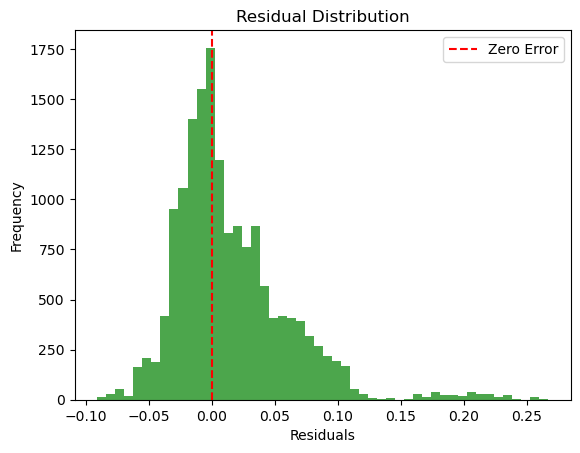

In [54]:
import matplotlib.pyplot as plt

y_pred = [pred for x in y_pred for pred in x]

residuals = y_test - y_pred

plt.hist(residuals, bins=50, alpha=0.7, color = 'green')
plt.axvline(x=0, color='red', linestyle='--', label='Zero Error')
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.legend()
plt.show()